# NLP981 Final Project - Phase #2

*   Instructor: Javad PourMostafa
*   Teaching Assistant: Parsa Abbasi
*   University of Guilan, 1st semester of 2019
*   GitHub repository : *https://github.com/JoyeBright/NLP*

In [1]:
!pip install keras
!pip install nltk
!pip install hazm
!pip install stopwords_guilannlp
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 317kB 5.9MB/s 
     |████████████████████████████████| 1.4MB 25.2MB/s 
     |████████████████████████████████| 235kB 29.8MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394469 sha256=cb9d129c83d44eb43a847618cb91c3f188cb16ba49fe4e6bb76a40d8bd6f070b
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154857 sha256=2bdf32fe4ee30eaf792ec8382fdc0814efe03dc999f5ea3082298d56a7fd2044
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
sentence = "Hello, world!"
print (nltk.word_tokenize(sentence))

['Hello', ',', 'world', '!']


It's the first phase of your final project for the *NLP981* course. The main idea behind this phase is to portray the develope side of *NLP*.

You must code inside of this python notebook. I highly recommend you to use the *Google Colab* environment. 

If you have any questions, feel free to ask.
You can use [*Quera*](https://quera.ir/course/4385/) platform for your general questions.



## Introduction

A category predictor is going to build at this phase of the project.

The predictor gets a text as input and predicts a category for that.

For this purpose, you need to :

1.   Load the dataset
2.   Preprocess the text data
3.   Implement a word representation method to represent each text as a numeric vector
4.   Implement a classification model and train that using the training set
5.   Predict a category for each of validation data using implemented model
6.   Measure your work using confusion matrix and some common metrics

**Important Note:** You can use any library you want in sections 1 and 2. But everything in section 3-6 need to be coded purely.



## 1) Dataset

The dataset you will use in this phase is called *Divar* that released by the *CafeBazaar* research team.

It contains more than 900,000 posts of the *Divar* ads platform. We split this dataset into training, validation, and testing sets.

The testing set is not accessible for you, and we use them to evaluate your work on the presentation day.

You can download the dataset files (training and validation sets) directly from the following link :

> *https://drive.google.com/open?id=1oj-fqpymjDr8QsOK-zQliiqXbVqakrFo*


### 1.1) Import

In [4]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import classification_report, confusion_matrix
from hazm import *
from stopwords_guilannlp import *
from nltk.tokenize import RegexpTokenizer
import numpy as np
import math
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
from string import punctuation
import random
    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#train_set = pd.read_csv('trainset.csv')
#valid_set = pd.read_csv('validationset.csv')

link = 'https://drive.google.com/open?id=1-D-AmUvc2fFOs53HWxoSRpy-6MtTlHRc'
st, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trainset.csv')  
train_set = pd.read_csv('trainset.csv')

link = 'https://drive.google.com/open?id=1-J4-W7HPdDowThY24hUoqCQGDW7iUNcN'
st, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('validationset.csv')  
valid_set = pd.read_csv('validationset.csv')



### 1.2) Analyzing

Display the top 10 rows of the train set.

In [5]:
print(train_set.head(10))

   Unnamed: 0  Unnamed: 0.1  archive_by_user                   brand                cat1                       cat2            cat3     city      created_at                                               desc              id  image_count   mileage platform     price                                     title   type  year
0           0        282086             True                     NaN            personal         clothing-and-shoes  shoes-belt-bag   Tehran     Monday 11AM  چکمه یکبار پوشیده شده قیمت 42\nکفش قهوه ای سوخ...  12875614029625            3       NaN   mobile     42000                                   سایز 40  women   NaN
1           1        762753             True        Samsung::سامسونگ  electronic-devices              mobile-tablet   mobile-phones   Tehran  Wednesday 12PM  گوشی رو تا حالا باز نکردم و تو جعبه پلمپه از د...  16051997226596            0       NaN   mobile    850000                      گوشی سامسونگ a3 2016    NaN   NaN
2           2        805240          

How many data (rows) stored in the training and validation sets?

In [6]:
train_len = train_set.shape[0]
valid_len = valid_set.shape[0]
print('Train set has {} rows.'.format(train_len))
print('Validation set has {} rows.'.format(valid_len))

Train set has 700000 rows.
Validation set has 147635 rows.


How many posts are in each category (First level categories)? (Based on training set)

In [7]:
cat1 = train_set["cat1"]



#Test set = Valid set
test_cat1 = valid_set["cat1"]



unique_cat1 = np.unique(cat1)

#in the following lines of code we print how many posts are in each category
cat1_posts_count = dict.fromkeys(unique_cat1, 0)
for cat in cat1:
  cat1_posts_count[cat] += 1

for cat, cnt in cat1_posts_count.items():
  print('Category "{}" contains {} posts.'.format(cat, cnt))
   

Category "businesses" contains 45660 posts.
Category "electronic-devices" contains 122905 posts.
Category "for-the-home" contains 214955 posts.
Category "leisure-hobbies" contains 61676 posts.
Category "personal" contains 102804 posts.
Category "vehicles" contains 152000 posts.


## 2) Preprocessing procedure

There are two kinds of text data in the dataset: *Title* and *Description*.

You can use the [*Stopwords Guilan NLP*](https://github.com/JoyeBright/stopwords_guilannlp) library to access a collection of Persian stop words.

In [8]:
#for faster result, we define the following lines of code outside the 'preprocessing' function
normalizer = Normalizer()
stopwords = stopwords_output("Persian", "nar")
lemmatizer = Lemmatizer()
stemmer = Stemmer()


def preprocessing(text):
    
    text = re.sub('<[^<]+?>','', text)
    text = ''.join(c for c in text if not c.isdigit())
    text = ''.join(c for c in text if c not in punctuation)
    text = normalizer.normalize(text)
    text = ' '.join(word for word in text.split() if word not in stopwords) # remove stopwors from text
    return text


   

## 3) Preparing the train and test data and create the model

### 3.1) Preprocessing

Preprocessing of raw data and preparing the train and test data.

In [9]:
column1 = "title"

dataset = train_set.append(valid_set)
dataset[column1] = dataset[column1].apply(preprocessing)
num_classes = len(unique_cat1)



# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each post.
MAX_SEQUENCE_LENGTH = 250
# The embedding dimension
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dataset[column1].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# print(word_index)

X = tokenizer.texts_to_sequences(dataset[column1].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Found 113878 unique tokens.
Shape of data tensor: (847635, 250)


In [11]:
rows_of_train = 250000
rows_of_test = 75000

Y = pd.get_dummies(dataset['cat1']).values
print('Shape of label tensor:', Y.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.4, random_state = 42)

X_train = X[0:rows_of_train]
X_test = X[rows_of_train: rows_of_train + rows_of_test]

Y_train = Y[0:rows_of_train]
Y_test = Y[rows_of_train:rows_of_train + rows_of_test]

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


Shape of label tensor: (847635, 6)
(250000, 250) (250000, 6)
(75000, 250) (75000, 6)


## 4) Classification

![alt text](https://cdn.lynda.com/course/578082/578082-637075371482276339-16x9.jpg)

### 4.1) LSTM model

The LSTM is implemented here.

Then we fit the training data into the classifier after implementation :

In [12]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3516/3516 [==============================] - 1542s 438ms/step - loss: 0.3610 - accuracy: 0.8808 - val_loss: 0.2552 - val_accuracy: 0.9191
Epoch 2/5
3516/3516 [==============================] - 1555s 442ms/step - loss: 0.1910 - accurac

## 5) Prediction

Now you can predict a category for each of the validation data using the implemented classifier.

In [13]:
Y_pred = model.predict(X_test)


## 6) Evaluation

It's time to evaluate your model using predicted categories for validation data.

You need to create a confusion matrix based on your prediction and the real labels. Then you can use this confusion matrix for calculation other measuring metrics. 

As this problem is a multi-class problem, the calculation formula is a little different from the general case. Read [this article](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) for more information.

### 6.1) Confusion matrix

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      4837
           1       0.95      0.94      0.95     13276
           2       0.94      0.94      0.94     23007
           3       0.92      0.89      0.90      6575
           4       0.93      0.93      0.93     11006
           5       0.92      0.96      0.94     16299

    accuracy                           0.92     75000
   macro avg       0.91      0.90      0.90     75000
weighted avg       0.92      0.92      0.92     75000

[[ 3593.    70.   532.    81.   170.   157.]
 [  123. 12454.   118.    86.    54.   219.]
 [  617.   152. 21664.   179.   240.   156.]
 [   84.    72.   133.  5848.   122.   129.]
 [  229.    51.   232.   162. 10211.    62.]
 [  191.   477.   328.   219.   209. 15576.]]





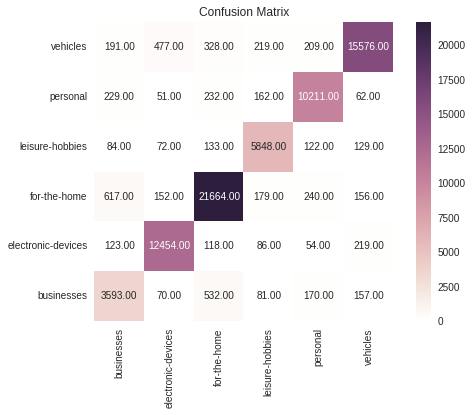

In [14]:
new_Y_pred = np.argmax(Y_pred, axis=1)
new_Y_test = np.argmax(Y_test, axis=1)

print(classification_report(new_Y_test, new_Y_pred))

mpl.style.use('seaborn')

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_Y_pred)):
        conf_arr[new_Y_pred[i]][new_Y_test[i]] += 1

print(conf_arr)

summ = conf_arr.sum()

df_cm = pd.DataFrame(conf_arr, 
  index = unique_cat1,
  columns = unique_cat1)

fig = plt.figure()

plt.clf()

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)

res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

res.invert_yaxis()

plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5], unique_cat1,va='center')

print('\n\n')

plt.title('Confusion Matrix')

plt.savefig('confusion_matrix.png', dpi=700, bbox_inches='tight' )

plt.show()

### 6.2) Accuracy

$$\text{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}$$

In [15]:
# Compute the accuracy of training data and validation data

corrects = 0
for i in range(len(new_Y_pred)):
    if int(new_Y_pred[i]) is int(new_Y_test[i]):
        corrects += 1
        
accuracy = float(corrects / len(new_Y_pred))*100
print('Accuracy (using "{}" column): {} %'.format (column1, accuracy))

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


Accuracy (using "title" column): 92.46133333333333 %
2344/2344 [==============================] - 90s 38ms/step - loss: 0.2445 - accuracy: 0.9246
Test set
  Loss: 0.244
  Accuracy: 0.925


### 6.3) Precision

$$\text{Precision} = \frac{TP}{TP + FP}$$

In [16]:
#Similar to the binary case, we can define precision for each of the classes
precision = []
#we append the precision for each class to the variable 'precision'
for i in range(num_classes):
  precision.append(conf_arr[i][i] / np.sum(conf_arr[i], axis = 0))

print('Precisions per classes are : {}'.format(precision))

macro_precision = 100 * np.sum(precision) / num_classes

print('Macro averaged Precision is : {} %'.format(macro_precision))

weighted_precision = 0
total = 0
for i in range(num_classes):
  weighted_precision += np.sum(conf_arr, axis = 0)[i] * precision[i]
  total += np.sum(conf_arr, axis = 0)[i]

weighted_precision = 100 * weighted_precision / total
print('Weighted Precision is : {} %'.format(weighted_precision))

Precisions per classes are : [0.780577883988703, 0.9540370767580818, 0.9415855354659249, 0.915466499686913, 0.9327669681191194, 0.916235294117647]
Macro averaged Precision is : 90.67782096893983 %
Weighted Precision is : 92.43127255432294 %


### 6.4) Recall

$$\text{Recall} = \frac{TP}{TP + FN}$$

In [17]:
#Similar to the binary case, we can define recall for each of the classes
recall = []
#We append the recall for each class to the variable 'recall'
for i in range(num_classes):
  recall.append(conf_arr[i][i] / np.sum(conf_arr, axis = 0)[i])
  
print('Recalls per classes are : {}'.format(recall))

macro_recall = 100 * np.sum(recall) / num_classes
print('Macro averaged Recall is : {} %'.format(macro_recall))

weighted_recall = 0
for i in range(num_classes):
  weighted_recall += np.sum(conf_arr, axis = 0)[i] * recall[i]

weighted_recall = 100 * weighted_recall / total
print('Weighted Recall is : {} %'.format(weighted_recall))  

Recalls per classes are : [0.742815794914203, 0.9380837601687255, 0.9416264615117138, 0.8894296577946768, 0.9277666727239687, 0.9556414503957298]
Macro averaged Recall is : 89.92272995848363 %
Weighted Recall is : 92.46133333333333 %


### 6.5) F1 score

$$\text{F1 score} = 2\times \frac{(Recall \times  Precision)}{Recall + Precision}$$ 

In [18]:
#F1-score is a function of precision and recall
#we can now compute the per-class F1-score
f1_score = []
for i in range(num_classes):
  f1_score.append( 2*( (recall[i]*precision[i]) / (recall[i]+precision[i])))

print('F1-scores per classes are : {}'.format(f1_score))

macro_f1 = 100 * np.sum(f1_score) / num_classes

print('Macro averaged F1-score is : {} %'.format(macro_f1))

weighted_f1 = 0
for i in range(num_classes):
  weighted_f1 += np.sum(conf_arr, axis = 0)[i] * f1_score[i]

weighted_f1 = 100 * weighted_f1 / total
print('Weighted F1-score is : {} %'.format(weighted_f1))  

F1-scores per classes are : [0.761228813559322, 0.9459931636916067, 0.941605998044116, 0.9022602792563449, 0.9302601011251309, 0.9355235892969758]
Macro averaged F1-score is : 90.28119908289159 %
Weighted F1-score is : 92.43133493386968 %


## 7) K-Fold Cross Validation *(Optional)*

Evaluate your model based on the K-Fold Cross Validation approach. This step is optional and has a few extra points.

In [ ]:
# Your implementation